In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [7]:
# Cấu hình
original_dir = "/kaggle/input/rice-leaf-disease-image"  # Adjust this after verifying dataset path
output_dir = "/kaggle/working/dataset"  # Use /kaggle/working for output to avoid permission issues
test_split = 0.2
IMAGE_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
random.seed(42)

# Verify dataset directory exists
if not os.path.exists(original_dir):
    raise FileNotFoundError(f"Dataset directory '{original_dir}' not found. Please check the dataset path in /kaggle/input/")
else:
    print(f"Found dataset directory: {original_dir}")
    print("Available classes:", os.listdir(original_dir))

# Tách dữ liệu thành train_val và test
train_val_dir = os.path.join(output_dir, 'train_val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Lặp qua từng lớp
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Tạo thư mục lớp trong train_val và test
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Lấy danh sách ảnh, shuffle
    images = os.listdir(class_path)
    random.shuffle(images)

    # Tách
    num_test = int(len(images) * test_split)
    test_images = images[:num_test]
    train_val_images = images[num_test:]

    # Di chuyển ảnh vào đúng nơi
    for img in tqdm(test_images, desc=f"Copying test images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

    for img in tqdm(train_val_images, desc=f"Copying train_val images for {class_name}"):
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(train_val_dir, class_name, img)
        )

print("✅ Đã tách dữ liệu thành công.")

# Kiểm tra cấu trúc dữ liệu
for root, dirs, files in os.walk(output_dir):
    print(root, ":", len(files), "files")


Found dataset directory: /kaggle/input/rice-leaf-disease-image
Available classes: ['Tungro', 'Bacterialblight', 'Blast', 'Brownspot']


Copying train_val images for Brownspot: 100%|██████████| 1280/1280 [00:01<00:00, 876.01it/s]

✅ Đã tách dữ liệu thành công.
/kaggle/working/dataset : 0 files
/kaggle/working/dataset/train_val : 0 files
/kaggle/working/dataset/train_val/Brownspot : 1280 files
/kaggle/working/dataset/train_val/Bacterialblight : 1268 files
/kaggle/working/dataset/train_val/Blast : 1152 files
/kaggle/working/dataset/train_val/Tungro : 1047 files
/kaggle/working/dataset/test : 0 files
/kaggle/working/dataset/test/Brownspot : 320 files
/kaggle/working/dataset/test/Bacterialblight : 316 files
/kaggle/working/dataset/test/Blast : 288 files
/kaggle/working/dataset/test/Tungro : 261 files


In [8]:
# Tạo ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
# Tạo generator cho tập train
train_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Tạo generator cho tập validation
val_generator = train_datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Tạo generator cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Số lượng lớp
NUM_CLASSES = train_generator.num_classes
class_labels = list(val_generator.class_indices.keys())

print(f"Số lớp: {NUM_CLASSES}")
print(f"Số lượng ảnh train: {train_generator.samples}")
print(f"Số lượng ảnh validation: {val_generator.samples}")
print(f"Số lượng ảnh test: {test_generator.samples}")


Found 3799 images belonging to 4 classes.
Found 948 images belonging to 4 classes.
Found 1185 images belonging to 4 classes.
Số lớp: 4
Số lượng ảnh train: 3799
Số lượng ảnh validation: 948
Số lượng ảnh test: 1185


In [9]:
# Hàm tạo model
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Fine-tuning: Mở khóa 20 lớp cuối
for layer in resnet_base.layers[:-20]:
    layer.trainable = False
for layer in resnet_base.layers[-20:]:
    layer.trainable = True

resnet_model = build_model(resnet_base)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("resnet50_rice_leaf_best.h5", monitor='val_loss', save_best_only=True, mode='min')


In [10]:
# Huấn luyện mô hình
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/30


I0000 00:00:1748788707.676084     121 service.cc:148] XLA service 0x7e565000b100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748788707.676778     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748788709.513968     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/60 ━━━━━━━━━━━━━━━━━━━━ 23:30 24s/step - accuracy: 0.2969 - loss: 1.3615

I0000 00:00:1748788716.618757     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5750 - loss: 1.0232 - val_accuracy: 0.2669 - val_loss: 1.7216 - learning_rate: 1.0000e-04
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 869ms/step - accuracy: 0.7492 - loss: 0.6477 - val_accuracy: 0.3724 - val_loss: 1.3786 - learning_rate: 1.0000e-04
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 869ms/step - accuracy: 0.7833 - loss: 0.5588 - val_accuracy: 0.2890 - val_loss: 1.3968 - learning_rate: 1.0000e-04
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 855ms/step - accuracy: 0.8179 - loss: 0.4897 - val_accuracy: 0.2563 - val_loss: 1.3989 - learning_rate: 1.0000e-04
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 853ms/step - accuracy: 0.8129 - loss: 0.4732 - val_accuracy: 0.4198 - val_loss: 1.6286 - learning_rate: 1.0000e-04
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 870ms/step - accuracy: 0.8322 - loss: 0.4473 - val_accuracy: 0.6245 - val_loss: 0.9762 - learning_rate: 1.0000e-04
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 856ms/step - accuracy: 0.8401 

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 677ms/step - accuracy: 0.9167 - loss: 0.2135
Validation Loss: 0.1646
Validation Accuracy: 0.9357
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.9686 - loss: 0.1071
Test Loss: 0.1065
Test Accuracy: 0.9679
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step
Test Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.96      0.98      0.97       316
          Blast       0.96      0.94      0.95       288
      Brownspot       0.96      0.97      0.97       320
         Tungro       0.98      0.98      0.98       261

       accuracy                           0.97      1185
      macro avg       0.97      0.97      0.97      1185
   weighted avg       0.97      0.97      0.97      1185



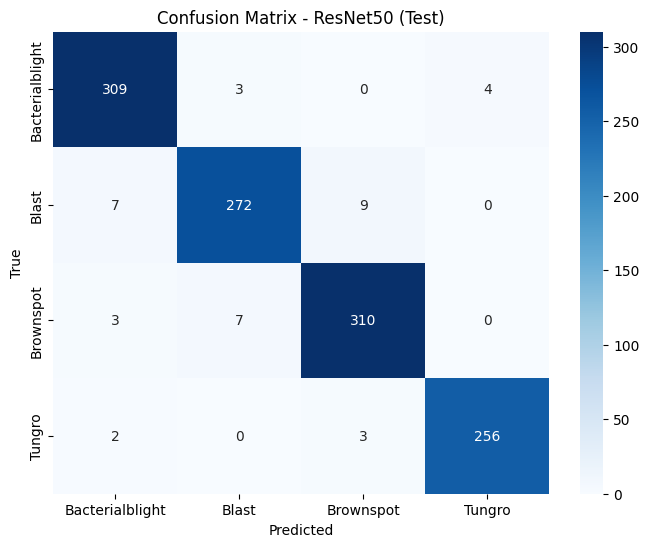

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 777ms/step
Validation Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.97      0.91      0.94       253
          Blast       0.87      0.93      0.90       230
      Brownspot       0.93      0.95      0.94       256
         Tungro       1.00      0.99      0.99       209

       accuracy                           0.94       948
      macro avg       0.94      0.94      0.94       948
   weighted avg       0.94      0.94      0.94       948



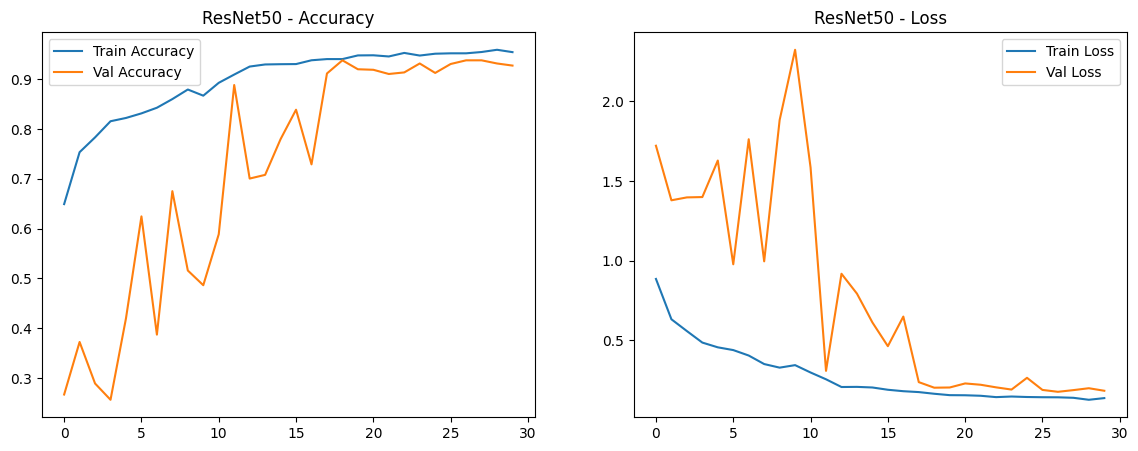

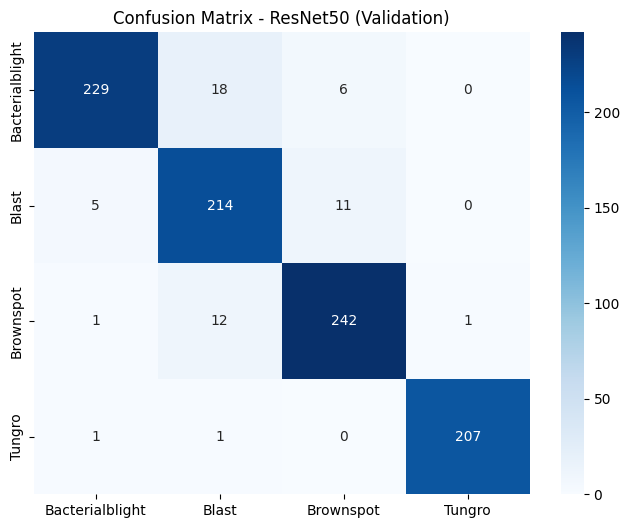

In [11]:
# Đánh giá mô hình trên tập validation
val_loss, val_acc = resnet_model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Đánh giá mô hình trên tập test (basic metrics)
test_loss, test_acc = resnet_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Phần đánh giá mô hình trên tập test (detailed)
test_generator.reset()  # Reset để đảm bảo thứ tự
test_preds = resnet_model.predict(test_generator)  # Updated to use resnet_model
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_generator.classes

# Báo cáo phân loại cho tập test
print("Test Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn cho tập test
test_conf_mat = confusion_matrix(test_y_true, test_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - ResNet50 (Test)")  # Updated title to reflect ResNet50
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix_test.png')
plt.show()

# Hàm vẽ biểu đồ lịch sử huấn luyện
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.savefig('training_history.png')

plot_history(resnet_history, "ResNet50")

# Đánh giá mô hình ResNet50 trên tập validation
val_generator.reset()
resnet_preds = resnet_model.predict(val_generator)
resnet_y_pred = np.argmax(resnet_preds, axis=1)
resnet_y_true = val_generator.classes

# Báo cáo phân loại
print("Validation Classification Report:")
print(classification_report(resnet_y_true, resnet_y_pred, target_names=class_labels))

# Ma trận nhầm lẫn
resnet_conf_mat = confusion_matrix(resnet_y_true, resnet_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(resnet_conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - ResNet50 (Validation)")
plt.savefig('confusion_matrix.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Test image path: /kaggle/working/dataset/test/Brownspot/brownspot_orig_037.jpg
True class: Brownspot
Predicted class: Brownspot
Confidence: 0.9721


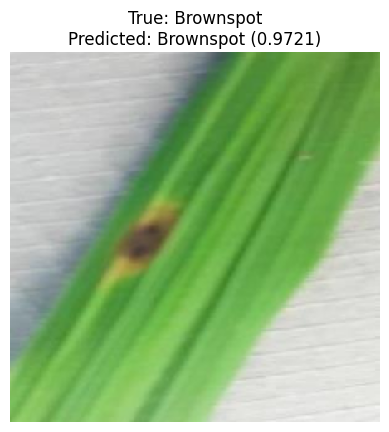

In [12]:
# Phần test ảnh ngẫu nhiên từ tập test
# Tải mô hình đã huấn luyện
model = tf.keras.models.load_model('resnet50_rice_leaf_best.h5')  # Updated model filename

# Lấy danh sách tất cả ảnh trong tập test
image_paths = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))

# Chọn ngẫu nhiên một ảnh
test_img_path = random.choice(image_paths)

# Tải và xử lý ảnh test
img = load_img(test_img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img) / 255.0  # Chuẩn hóa ảnh
img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch

# Dự đoán lớp
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Lấy nhãn thật từ đường dẫn
true_class = os.path.basename(os.path.dirname(test_img_path))

# Hiển thị kết quả
print(f"Test image path: {test_img_path}")
print(f"True class: {true_class}")
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

# Hiển thị ảnh test
plt.figure()
plt.imshow(img)
plt.title(f"True: {true_class}\nPredicted: {class_labels[predicted_class]} ({confidence:.4f})")
plt.axis('off')
plt.savefig('test_result.png')

# Lưu mô hình
resnet_model.save("resnet50_rice_final.h5")  # Updated model filename
